In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
adata = sc.read('../Data/adata_with_embeddings.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 3273 × 30865
    obs: 'scan-b external id', 'instrument model', 'age at diagnosis', 'tumor size', 'lymph node group', 'lymph node status', 'er status', 'pgr status', 'her2 status', 'ki67 status', 'nhg', 'er prediction mgc', 'pgr prediction mgc', 'her2 prediction mgc', 'ki67 prediction mgc', 'nhg prediction mgc', 'er prediction sgc', 'pgr prediction sgc', 'her2 prediction sgc', 'ki67 prediction sgc', 'pam50 subtype', 'overall survival days', 'overall survival event', 'endocrine treated', 'chemo treated'
    obsm: 'X_ae'

In [38]:
sc.pp.neighbors(adata, use_rep='X_ae', n_neighbors=7, knn=True)

In [45]:
sc.tl.umap(adata, min_dist=.1)#, spread=.5)

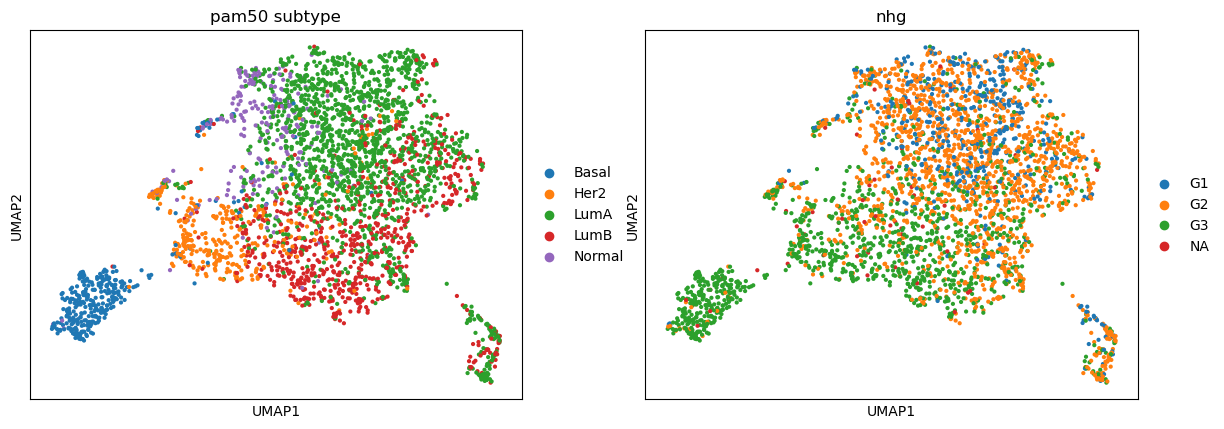

In [49]:
sc.pl.umap(adata, color=['pam50 subtype','nhg'])

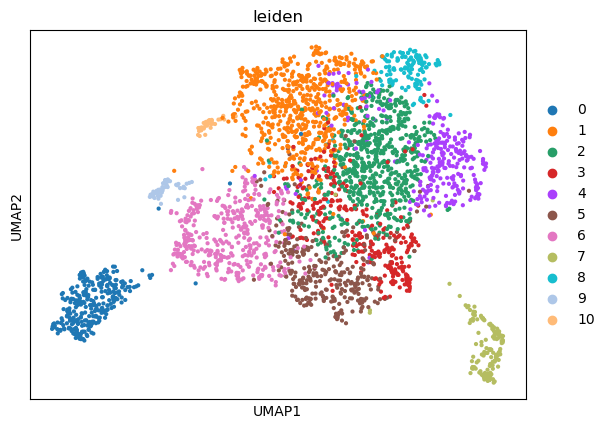

In [51]:
sc.tl.leiden(adata,flavor="igraph", n_iterations=2, resolution=.7)
sc.pl.umap(adata,color='leiden')

In [62]:
markers = {'Basal':['KRT5', 'KRT14', 'KRT17', 'EGFR', 'TP63', 'CDH3'],
'LumA':['ESR1', 'PGR', 'GATA3', 'FOXA1', 'BCL2', 'MLPH'],
'LumB':['ESR1', 'PGR', 'MKI67', 'CCNB1', 'MYBL2', 'CDC20', 'BIRC5'],
'Her2+':['ERBB2', 'GRB7', 'FGFR4', 'CDK12', 'TIMP1', 'PPP1R1B'],
'Normal-like':['TP63', 'MMP14', 'VIM', 'CD24', 'KRT18', 'KRT19', 'FABP4', 'ADH1B']}


In [64]:
for k,v in markers.items():
    sc.tl.score_genes(adata, gene_list=v, score_name=k)

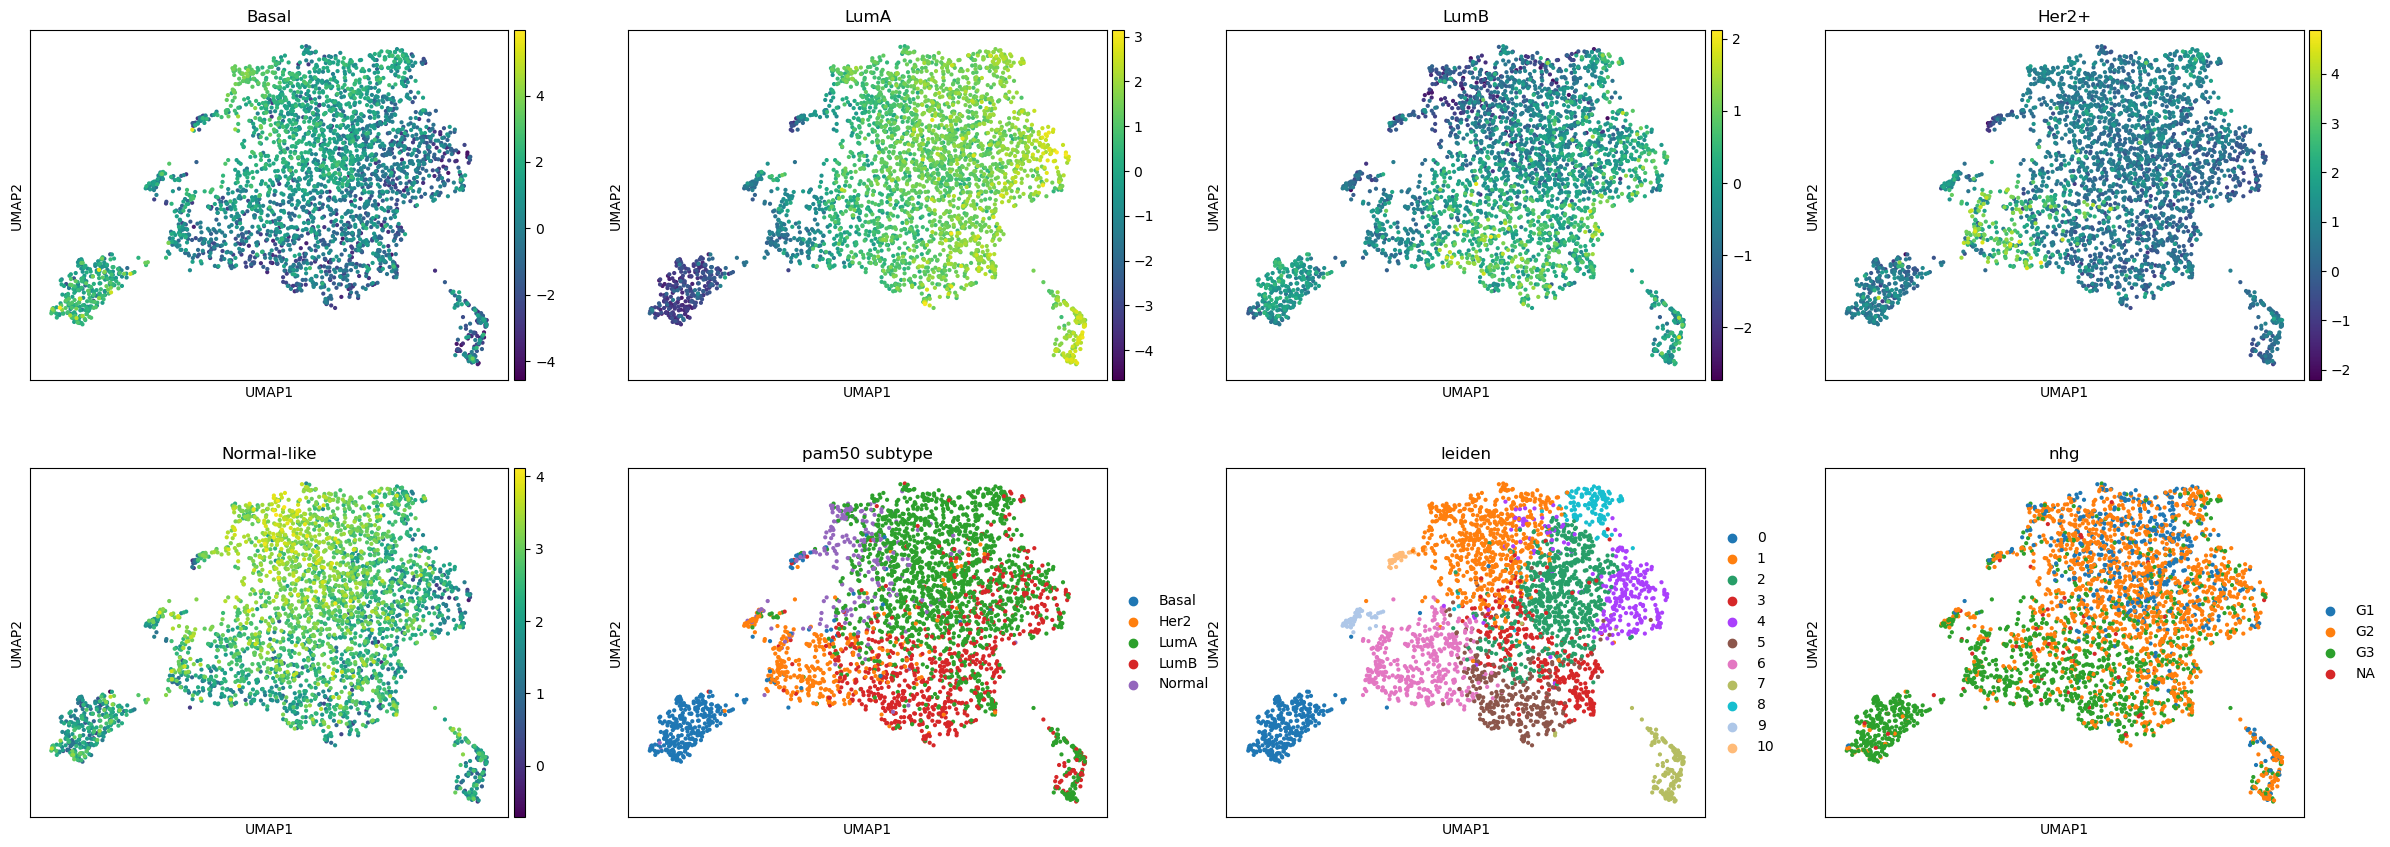

In [71]:
sc.pl.umap(adata, color=list(markers.keys())+['pam50 subtype', 'leiden','nhg'])

In [55]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.tl.dendrogram(adata, groupby='leiden', use_rep='X_ae')

/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:455: 

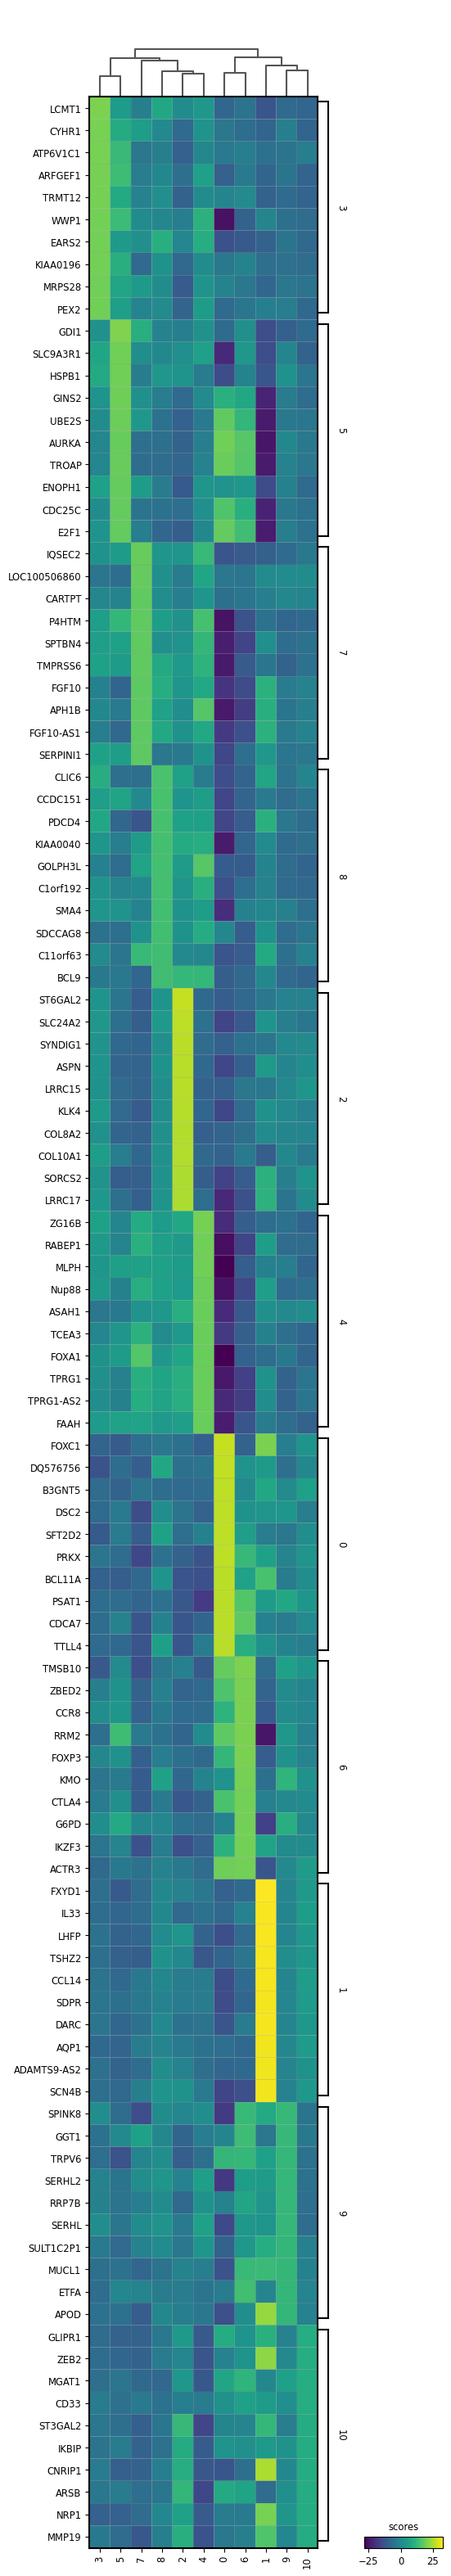

In [60]:
sc.pl.rank_genes_groups_matrixplot(
    adata,
    groupby='leiden',
    dendrogram=True,
    values_to_plot='scores',
    standard_scale='group',
    swap_axes=True
)